In [1]:
# Load in necessary functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')


from mpl_toolkits import mplot3d      

import matplotlib.ticker as mticker

import seaborn as sns; sns.set()

from sklearn import mixture
from sklearn.cluster import DBSCAN, MiniBatchKMeans, AffinityPropagation
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import time
import warnings

import geopandas as gpd
import earthpy as et
from shapely.geometry import Point
import shapely.geometry as geom

import heapq

import random
import os, errno
import sys
import time
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.cluster import KMeans



In [2]:
# feature selection - select subset of meaningful features
# feature extraction - derive information building a new feature subspace

In [3]:
# Load in earthquake and fault data sets

# Earthquakes
eq = pd.read_csv('Results_likeliest.csv')
eq_gpd = gpd.GeoDataFrame(eq, geometry=[Point(x, y) for x, y in zip(eq.lon, eq.lat)])

# Entire Community Fault Model
CFM1 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_blind.shp')
CFM2 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_nonblind.shp')
CFM_full = pd.concat([CFM1, CFM2],axis=0).reset_index()

# Fault Lookup Table 
fault_lookup = pd.read_csv('Data/CFM_5_Fault_to_Number_Matchup.csv')

In [4]:
print(eq_gpd.columns)
print(eq_gpd.shape)
eq_gpd.head()

Index(['Unnamed: 0', 'cuspid', 'lat', 'lon', 'depth', 'magnitude',
       'focal_mechanism_1_strike', 'focal_mechanism_1_dip',
       'focal_mechanism_1_rake', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'fault_index_ 1', 'fault_index_ 2', 'fault_index_ 3',
       'fault_index_ 4', 'fault_index_ 5', 'probability_ 1', 'probability_ 2',
       'probability_ 3', 'probability_ 4', 'probability_ 5', 'distance_ 1',
       'distance_ 2', 'distance_ 3', 'distance_ 4', 'distance_ 5', 'geometry'],
      dtype='object')
(13159, 31)


Unnamed: 0   cuspid       lat        lon   depth  magnitude  \
0           1  3301609  36.04350 -118.27383  11.180       3.13   
1           2  3301757  33.93330 -118.67763  13.389       3.20   
2           3  3301835  36.09100 -120.81367   0.180       3.49   
3           4  3315786  36.94300 -121.29500   4.770       4.79   
4           5  3315878  36.13917 -120.68150   2.600       3.30   

   focal_mechanism_1_strike  focal_mechanism_1_dip  focal_mechanism_1_rake  \
0                      59.0                   72.0                   -85.0   
1                     124.0                   30.0                   126.0   
2                       NaN                    NaN                     NaN   
3                       NaN                    NaN                     NaN   
4                       NaN                    NaN                     NaN   

   year  ...  probability_ 2  probability_ 3  probability_ 4  probability_ 5  \
0  1981  ...           0.160           0.110            0.00           0.000   
1  1981  ...           0.305           0.164            0.03           0.007   
2  1981  ...           0.000           0.000            0.00           0.000   
3  1981  ...           0.000           0.000            0.00           0.000   
4  1981  ...           0.002           0.000            0.00           0.000   

      distance_ 1     distance_ 2  distance_ 3  distance_ 4  distance_ 5  \
0  NA: Not in CFM            8170         7301       124221       128078   
1            5556  NA: Not in CFM         5592        11064        11965   
2  NA: Not in CFM          353031       312586       370552       202155   
3  NA: Not in CFM          393656       326160       426487       304007   
4  NA: Not in CFM           18626       340449       299537       358845   

                     geometry  
0  POINT (-118.27383 36.0435)  
1  POINT (-118.67763 33.9333)  
2   POINT (-120.81367 36.091)  
3     POINT (-121.295 36.943)  
4  POINT (-120.6815 36.13917)  

[5 rows x 31 columns]

In [5]:
print(CFM_full.columns)
CFM_full.head()

Index(['index', 'Layer', 'belowTopoA', '_isBlind', 'midZ', 'geometry'], dtype='object')


index                                              Layer  belowTopoA  \
0      0          WTRA-ORFZ-MULT-Oak_Ridge_fault-CFM5-trace    -863.474   
1      1          WTRA-ORFZ-MULT-Oak_Ridge_fault-CFM5-trace    -863.474   
2      2  WTRA-ORFZ-OFFS-Mid_Channel_fault-SRLN-CVMH-CFM...    -766.559   
3      3    WTRA-ORFZ-SFNV-Northridge_Frew_fault-CFM2-trace   -7600.930   
4      4      OCBA-DSCS-MAIN-Descanso_fault-SRLN-CFM5-trace    -149.117   

  _isBlind    midZ                                           geometry  
0        1  -687.0  LINESTRING Z (-119.2682619892364 34.2460688354...  
1        1 -2220.0  LINESTRING Z (-119.3116024068266 34.2325375511...  
2        1 -1543.0  LINESTRING Z (-119.3799464479696 34.1735614150...  
3        1 -7895.0  LINESTRING Z (-118.7133510887424 34.4189450390...  
4        1  -779.0  LINESTRING Z (-117.2227294341234 32.5120932815...

In [8]:
CFM_full.shape

(479, 6)

In [6]:
print(fault_lookup.columns)
print(len(set(fault_lookup.fault_clean)))
fault_lookup.head()

Index(['Unnamed: 0', 'fault', 'number', 'fault_clean'], dtype='object')
312


Unnamed: 0                                              fault  number  \
0           1           BNRA-BMFZ-MULT-Black_Mountain_fault-CFM3       1   
1           2    BNRA-NDVZ-MULT-Northern_Death_Valley_fault-CFM2       2   
2           3  BNRA-SDVZ-MULT-Southern_Death_Valley_fault-ver...       3   
3           4                 CRFA-BPPM-EAST-Big_Pine_fault-CFM4       4   
4           5          CRFA-BPPM-LCKV-Lockwood_Valley_fault-CFM2       5   

                            fault_clean  
0                  Black_Mountain_fault  
1           Northern_Death_Valley_fault  
2  Southern_Death_Valley_fault-vertical  
3                        Big_Pine_fault  
4                 Lockwood_Valley_fault

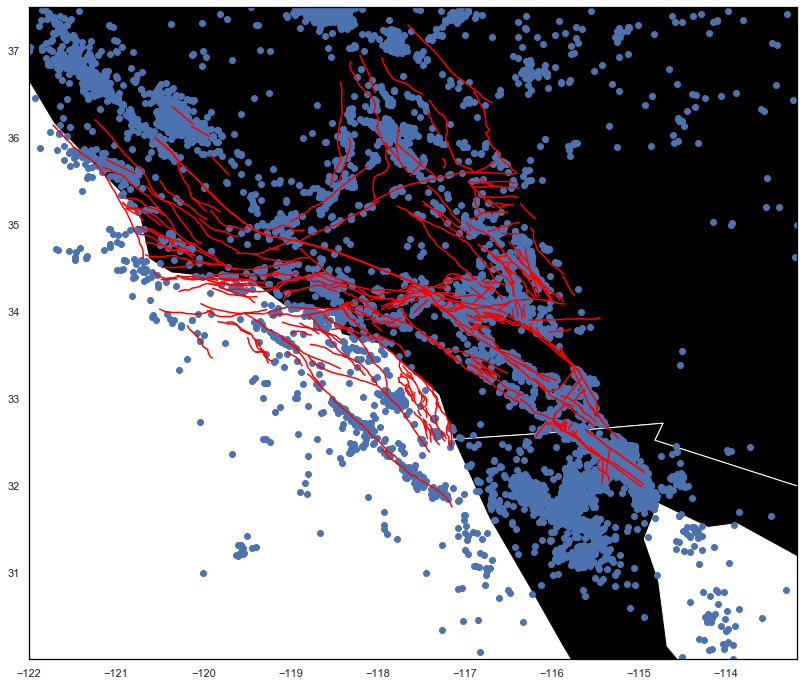

In [7]:
# Set up Figure
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.setp(ax.spines.values(), color='black')

# Plot the Basemap
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')

# Plot the faults and earthquakes
eq_gpd.plot(ax=ax)
CFM_full.plot(ax=ax, color = 'red')

# Set the view limit to only area of interest
ax.set_xlim(min(eq_gpd.lon),max(eq_gpd.lon))
ax.set_ylim(min(eq_gpd.lat),max(eq_gpd.lat));

# Unsupervised Clustering - Can we assign earthquakes to faults with little to no effort?

In [41]:
data = eq_gpd[['lon','lat']].values
data[:10]

array([[-118.27383,   36.0435 ],
       [-118.67763,   33.9333 ],
       [-120.81367,   36.091  ],
       [-121.295  ,   36.943  ],
       [-120.6815 ,   36.13917],
       [-116.76278,   33.50598],
       [-117.34383,   37.179  ],
       [-116.17884,   33.83515],
       [-120.03667,   36.00217],
       [-120.18616,   36.17783]])

In [49]:
# Let set up the K means approach
# Initially we will try a low number of clusters to refresh on the approach

repeats = 10 # Remember there is stochasticity involved, so we do 10 repeats to collect some error estimates.
kClusters = 50 # Going up to 50 as out "guess" takes time, but it can be worth it

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        X=data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(X)
        criteriaAIC_BIC[rep,0,nr]=model.aic(X)
        criteriaAIC_BIC[rep,1,nr]=model.bic(X)

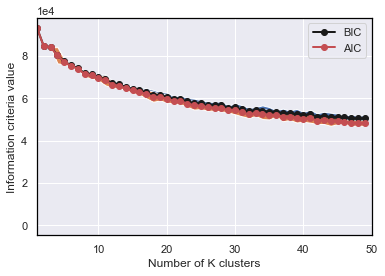

In [50]:
# Solve for and plot the two error criteria

meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[5:]), np.max(meanBIC))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,kClusters-1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

(30.010170000000002, 37.5)

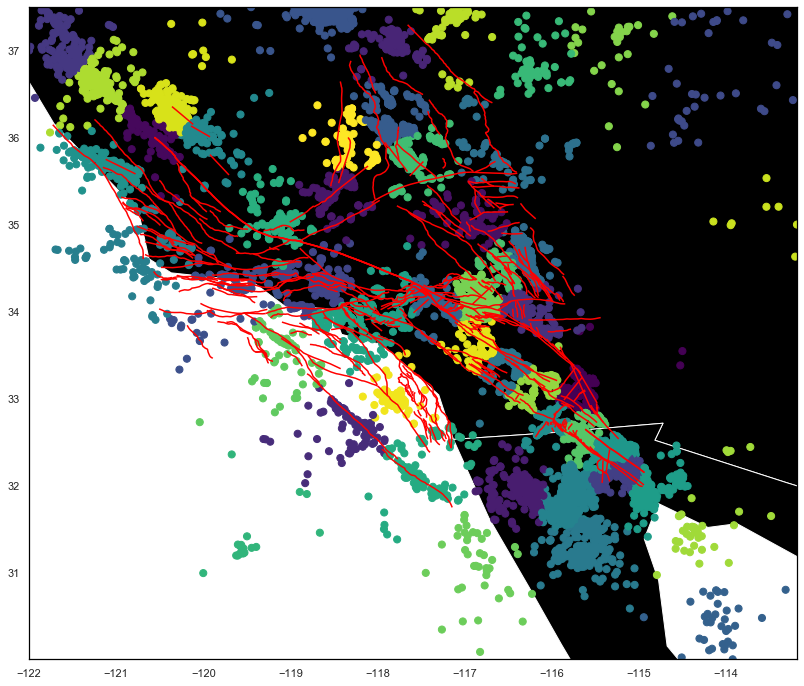

In [71]:
# Let's see what this looks like on the data
# Choose the cluster guess from the previous step

# Set up Figure
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.setp(ax.spines.values(), color='black')

# Plot the Basemap
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')

# Plot the faults
CFM_full.plot(ax=ax, color = 'red')

# Let's see what this looks like on the data
# Choose the cluster guess from the previous step
clusterGuess=50

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Set the view limit to only area of interest
ax.set_xlim(min(eq_gpd.lon),max(eq_gpd.lon))
ax.set_ylim(min(eq_gpd.lat),max(eq_gpd.lat));

312


(30.010170000000002, 37.5)

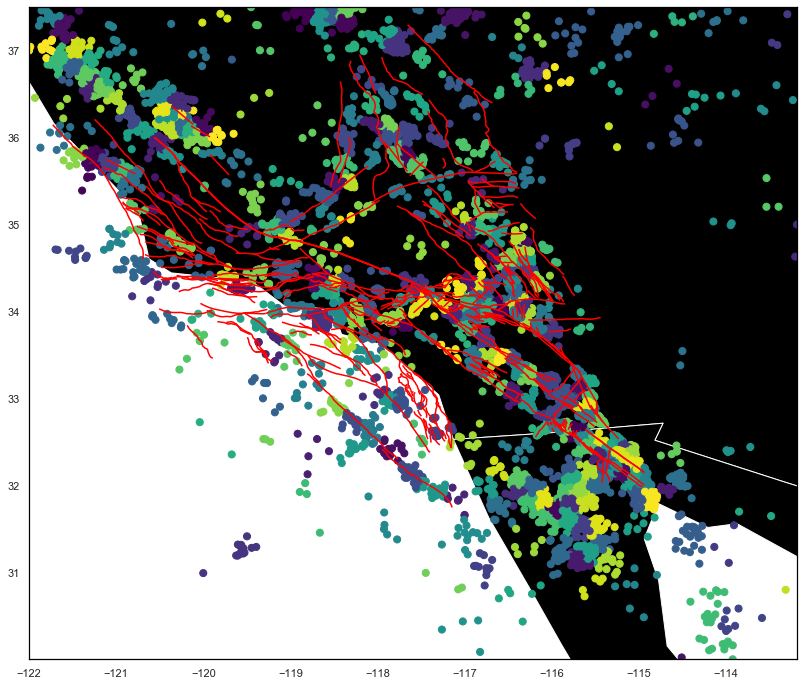

In [70]:
# Let's try the number of clusters expected given the number of faults in the model
print(len(set(fault_lookup.fault_clean)))

# Set up Figure
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.setp(ax.spines.values(), color='black')

# Plot the Basemap
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')

# Plot the faults
CFM_full.plot(ax=ax, color = 'red')

# Let's see what this looks like on the data
# Choose the cluster guess from the previous step
clusterGuess=len(set(fault_lookup.fault_clean))

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Set the view limit to only area of interest
ax.set_xlim(min(eq_gpd.lon),max(eq_gpd.lon))
ax.set_ylim(min(eq_gpd.lat),max(eq_gpd.lat));

# K Means seems ineffective at our task. Let's try additional clustering algorithms.

Automatically created module for IPython interactive environment


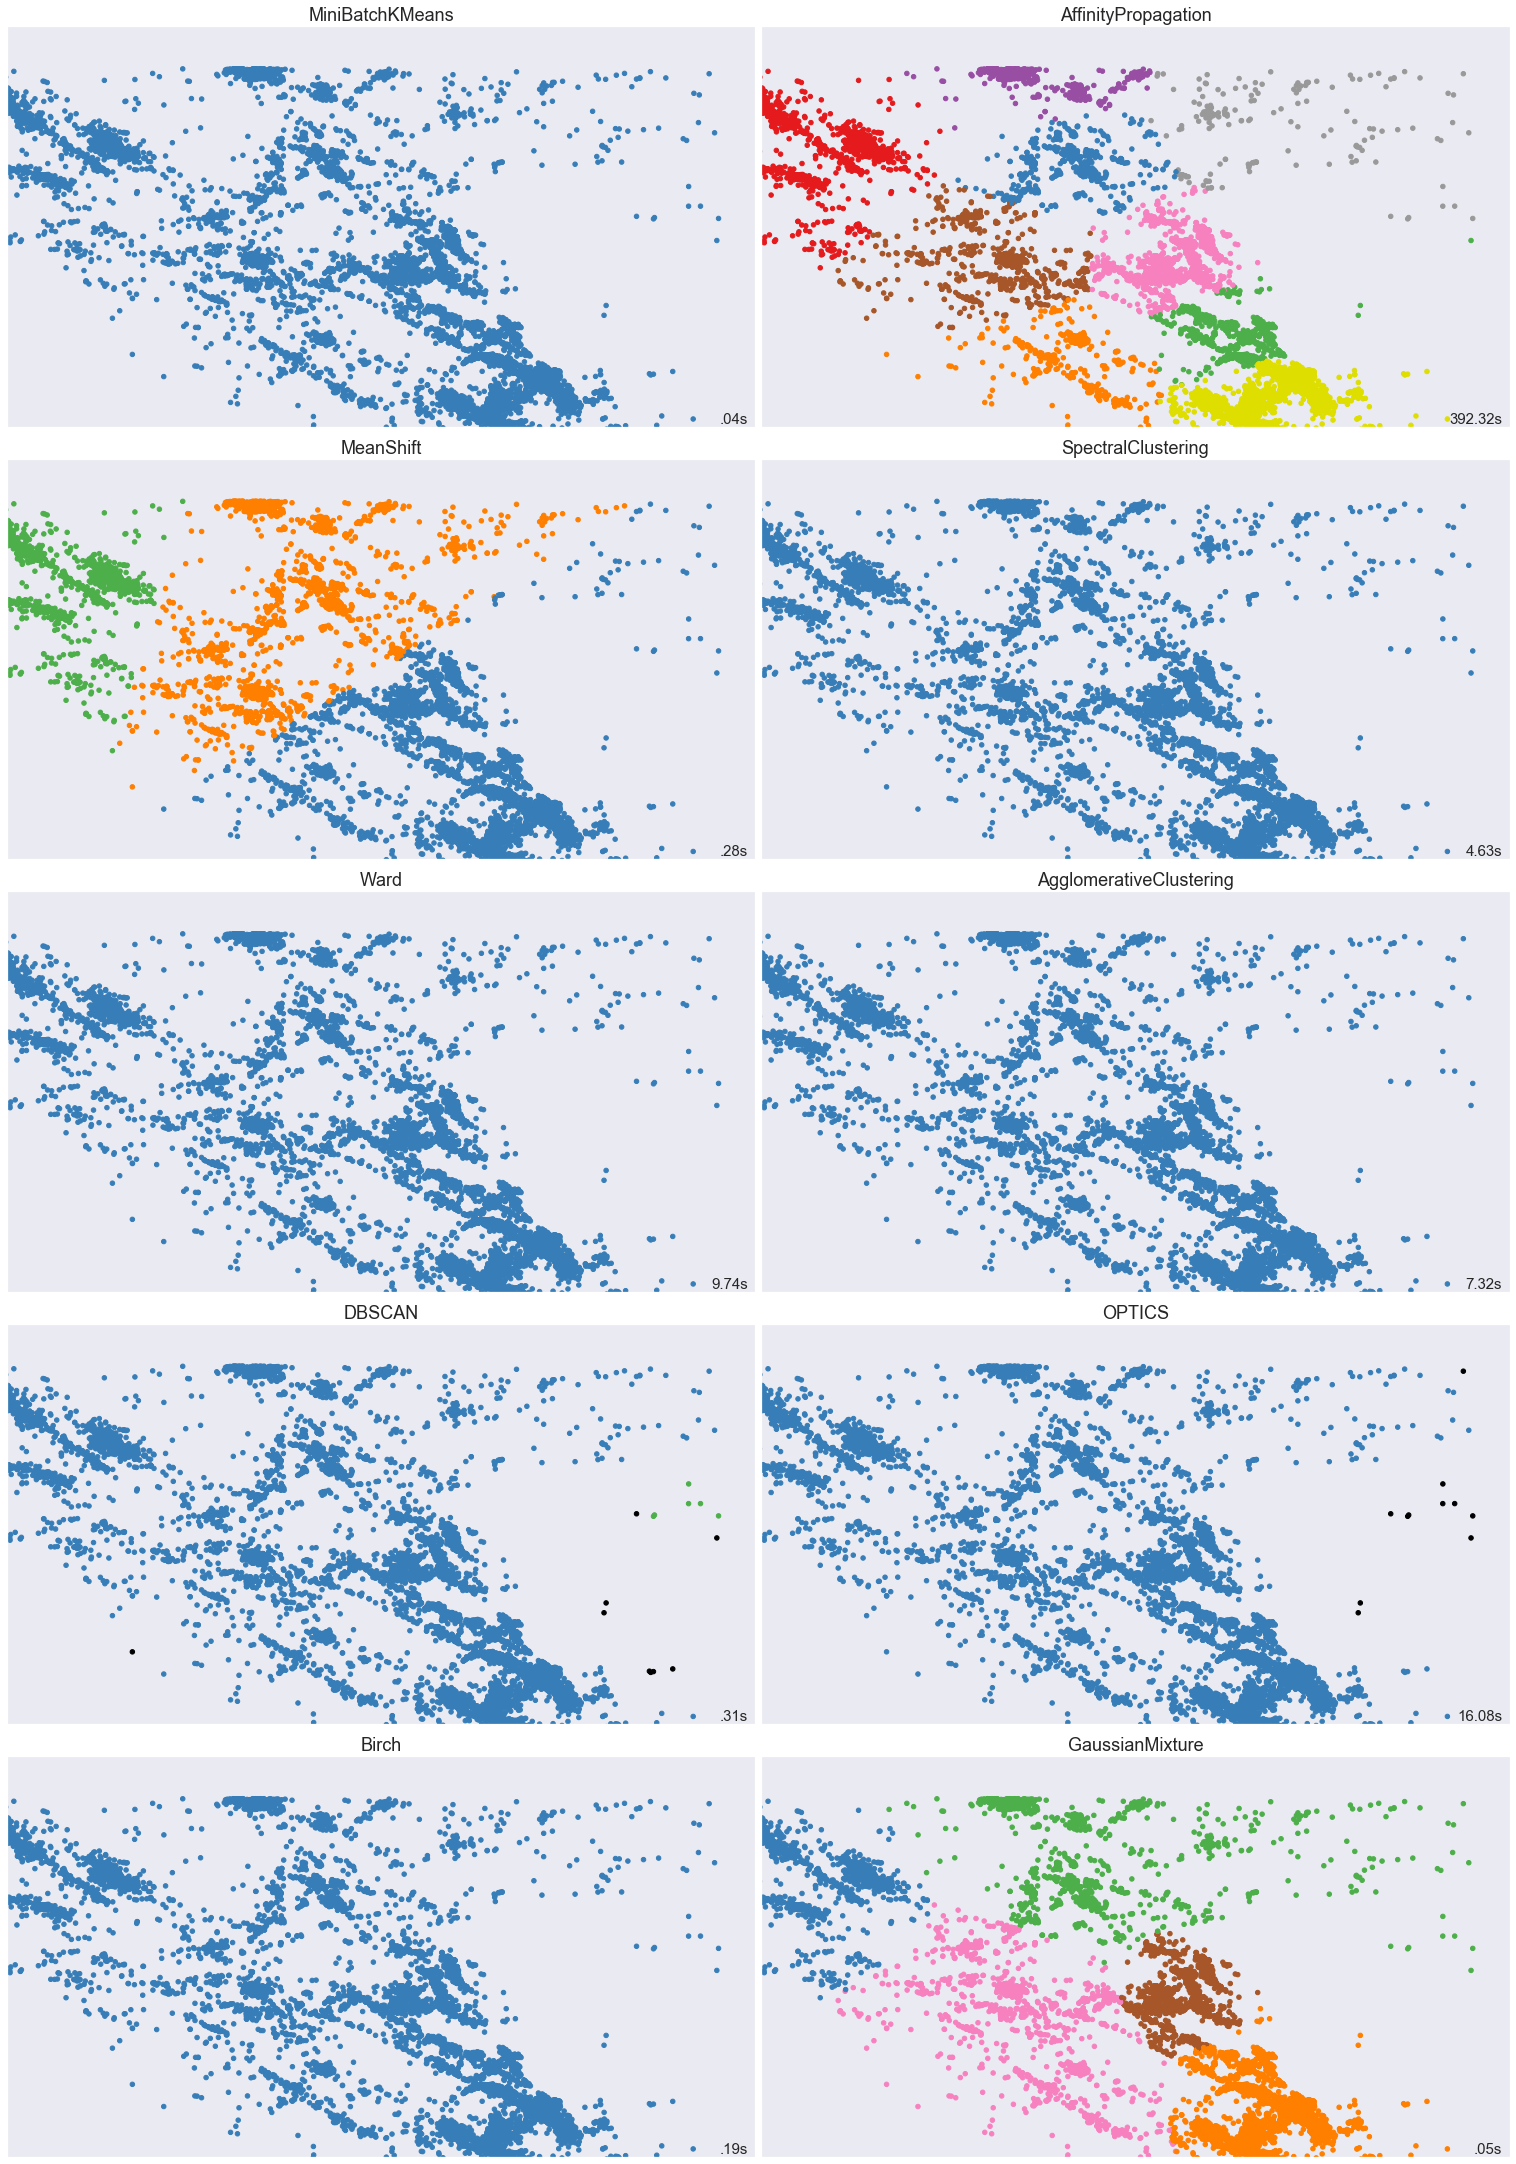

In [87]:
print(__doc__)
import inspect
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]



np.random.seed(0)
n_clusters = 1

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 30))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 100,
                'n_clusters': 5,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.2}

datasets = [data]

for dataset in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()

    X = dataset[1]

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    
    ward = cluster.AgglomerativeClustering(
        n_clusters=n_clusters, linkage='ward',
        connectivity=connectivity)
    
    spectral = cluster.SpectralClustering(
        n_clusters=n_clusters, eigen_solver='arpack',
        affinity="nearest_neighbors")
    
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=n_clusters, connectivity=connectivity)
    
    birch = cluster.Birch(n_clusters=n_clusters)
    
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            

        plt.subplot(len(datasets)*5, len(clustering_algorithms)/5, plot_num)
        plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=20, color=colors[y_pred])
        
        # add plot enhancers
        #world = gpd.read_file('Data/naturalearth_lowres.shp')
        base = world.plot(ax=ax,color='black', edgecolor='white')
        #ax.set_aspect('equal')
        ax.set_facecolor('white')
        plt.setp(ax.spines.values(), color='black')
        CFM_full.plot(ax=ax, color = 'red')

        plt.xlim(-2.5, 2.5)
        plt.ylim(-1.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
plt.show()

In [88]:
# The algorithmic complexity of affinity propagation is quadratic in the number of points.

# Let's assume that the probabalistic approach (Walker et al., 2019) is correct in its associations. Can we learn this model with K-NN and employ a supervised learning technique? If so, then perhaps we would be able to apply it to northern CA.

In [102]:
eq_gpd['fault_index_ 1'].head(10)

0    326
1    289
2    326
3    326
4    326
5    326
6    326
7    213
8    326
9    326
Name: fault_index_ 1, dtype: int64

In [98]:
# We know from out expert analysis that some earthquakes do not occur on faults within the catalogue.
# These are labeled with 326
print(len(eq_gpd[eq_gpd['fault_index_ 1'] == 326]))
print(len(eq_gpd[eq_gpd['fault_index_ 1'] != 326]))

eq_gpd_fault = eq_gpd[eq_gpd['fault_index_ 1'] != 326]

4246
8913


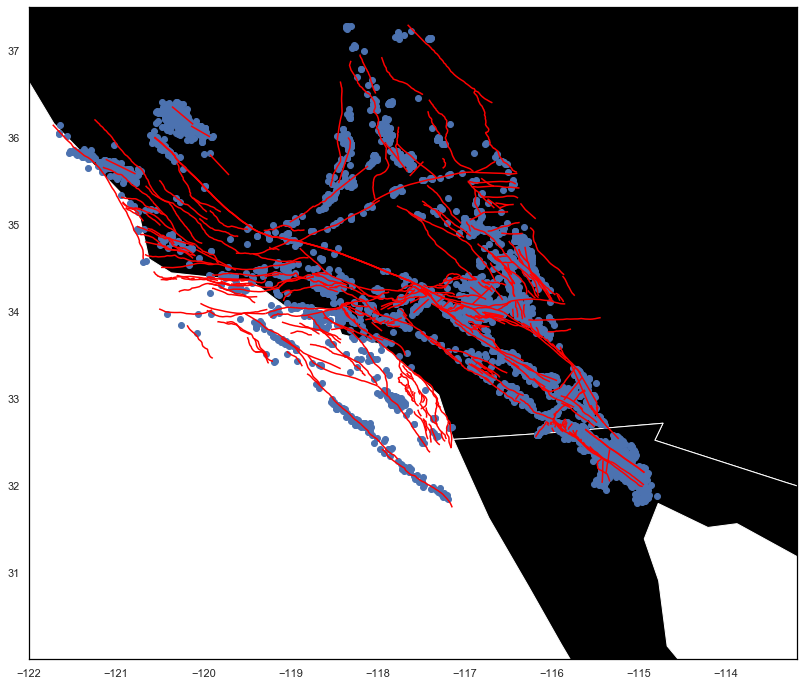

In [99]:
# Let's see what this new dataset looks like

# Set up Figure
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.setp(ax.spines.values(), color='black')

# Plot the Basemap
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')

# Plot the faults and earthquakes
#eq_gpd.plot(ax=ax)
eq_gpd_fault.plot(ax=ax)
CFM_full.plot(ax=ax, color = 'red')

# Set the view limit to only area of interest
ax.set_xlim(min(eq_gpd.lon),max(eq_gpd.lon))
ax.set_ylim(min(eq_gpd.lat),max(eq_gpd.lat));

In [130]:
# How many number of instances of earthquakes on each fault are there in our dataset?
eq_counts = eq_gpd_fault['fault_index_ 1'].value_counts()

eq_counts_df = pd.DataFrame(
    {"Number of instances": eq_counts},
    ).rename_axis("Fault")

display(eq_counts_df)



Number of instances
Fault                     
156                    756
173                    516
69                     494
68                     446
277                    414
50                     395
249                    336
29                     297
37                     261
34                     208
250                    193
261                    187
67                     173
265                    171
110                    169
129                    146
228                    110
48                     102
19                     100
252                     89
41                      79
181                     78
189                     78
223                     77
54                      75
51                      72
109                     68
56                      66
77                      64
20                      53
...                    ...
132                      1
172                      1
215                      1
271                      1
274                      1
32                       1
83                       1
286                      1
305                      1
66                       1
165                      1
313                      1
237                      1
301                      1
145                      1
14                       1
291                      1
117                      1
33                       1
93                       1
1                        1
320                      1
312                      1
304                      1
296                      1
260                      1
158                      1
123                      1
13                       1
236                      1

[274 rows x 1 columns]

In [122]:
print(fault_lookup[fault_lookup['number'] == 69]['fault_clean'].item())
print(fault_lookup[fault_lookup['number'] == 68]['fault_clean'].item())
print(fault_lookup[fault_lookup['number'] == 173]['fault_clean'].item())
print(fault_lookup[fault_lookup['number'] == 277]['fault_clean'].item())

Hector_Mine_rupture_dipping
Landers_rupture_detailed_splays
Sierra_Cucapah_fault
Northridge-Frew_fault


# The dataset is highly imbalanced, so we will need to split it correctly so that we don't lose a lot of information in the test set. Now, we'll use the stratify option to split the data in such a way that the relative class frequencies are preserved (the code is provided).

In [273]:
data_train, data_test = train_test_split(eq_gpd_fault, test_size=.4, 
                                         stratify=eq_gpd_fault['fault_index_ 1'], random_state=99)

In [274]:
# Unfortunately, we will have to lose the entries that only have a frequency of 1
faults_with_over_one_eq = np.asarray(eq_counts_df[eq_counts_df["Number of instances"] > 1].index)
print(len(faults_with_over_one_eq))

eq_gpd_fault = eq_gpd_fault[eq_gpd_fault['fault_index_ 1'].isin(faults_with_over_one_eq)]


230


In [275]:
# We only need the lat, long, and fault association
eq_gpd_fault = eq_gpd_fault[['lon','lat','fault_index_ 1']]

In [276]:
# Now let's try the stratified split
data_train, data_test = train_test_split(eq_gpd_fault, test_size=.25, 
                                         stratify=eq_gpd_fault['fault_index_ 1'], random_state=99)

In [315]:
# your code here
X = data_train.iloc[:,:-1].values
y = data_train.iloc[:,-1].values

In [278]:
# Let's see what the input variable looks like
# This should be out lat lon inputs

print(X)

[[-120.41423   36.26804]
 [-120.49538   35.92399]
 [-115.31807   32.48561]
 ...
 [-118.45427   33.9336 ]
 [-117.69796   34.14801]
 [-115.26035   32.23075]]


In [316]:
# Let's see what the output variable looks like
# This should be our fault classes

print(y)

[ 50 228 249 ... 122 324 156]


In [337]:
# create all plot colors for classe s
cmap = matplotlib.cm.get_cmap('hsv')
class_labels = np.unique(y)
num_classes = len(class_labels)
color_val = np.linspace(0., 1., num_classes)
class_colors = []

for ii in color_val: 
    class_colors.append(cmap(ii))

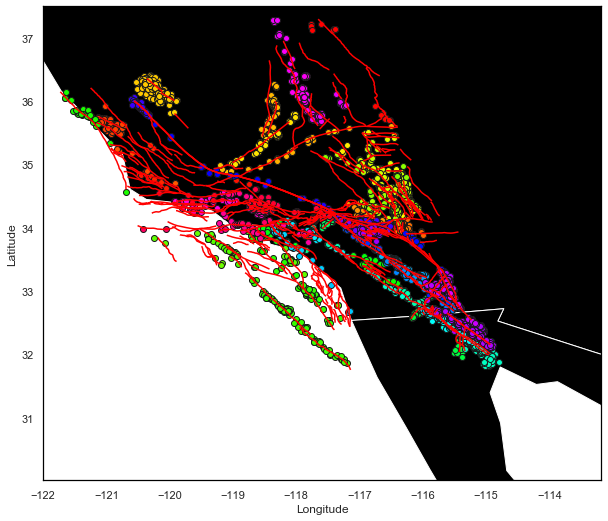

In [458]:
# Let's plot these


def plot_eq_data(ax, X, y, class_colors):
    class_labels = np.unique(y)

    for ii, c in enumerate(class_labels):
        subset = X[y == c]
        ax.scatter(subset[:, 0], subset[:, 1], color = class_colors[ii], edgecolor = 'k')  
    ax.set(xlabel='Longitude', ylabel='Latitude')

fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor('white')
plt.setp(ax.spines.values(), color='black')
base = world.plot(ax=ax,color='black', edgecolor='white')
CFM_full.plot(ax=ax, color = 'red')
#plot_eq_data(ax, X[0:900, :], y[0:900], class_colors)
plot_eq_data(ax, X, y, class_colors)

# Set the view limit to only area of interest
ax.set_xlim(min(eq_gpd.lon),max(eq_gpd.lon))
ax.set_ylim(min(eq_gpd.lat),max(eq_gpd.lat));

In [400]:
# You can set the number of nearest neighbors the K-NN considers
# These are the points closest to a given point it would like to classify

k_vals = list(range(1, 100))
train_scores = [KNeighborsClassifier(n_neighbors=k).fit(X, y).score(X, y) for k in k_vals]
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, cv=2) for k in k_vals]

Best k: 3


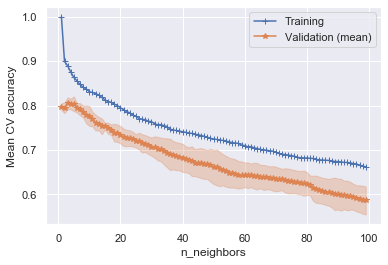

In [401]:
# Plot the results - It seems to do better when less neighbors are considered

def plot_cv(ax, hyperparameter, cv_scores):

    cv_means = np.mean(cv_scores, axis=1)
    cv_stds = np.std(cv_scores, axis=1)
    handle, = ax.plot(hyperparameter, cv_means, '-*', label="Validation (mean)")
    plt.fill_between(hyperparameter, cv_means - 2.*cv_stds, cv_means + 2.*cv_stds, alpha=.3, color=handle.get_color())
    
    
fig, ax = plt.subplots()
ax.plot(k_vals, train_scores, '-+', label="Training")
plot_cv(ax, k_vals, cv_scores)
plt.xlabel("n_neighbors")
plt.ylabel("Mean CV accuracy");
plt.legend()

best_k = k_vals[np.argmax(np.mean(cv_scores, axis=1))]
print("Best k:", best_k)

best_knn_clf = KNeighborsClassifier(n_neighbors=best_k).fit(X, y)

In [455]:
# Lets print the accuracy on the training and test set
X_test = data_test.iloc[:,:-1].values
y_test = data_test.iloc[:,-1].values

model_knn = KNeighborsClassifier(n_neighbors=3).fit(X, y)
y_pred_train = model_knn.predict(X)
accuracy_train = accuracy_score(y, y_pred_train)

y_pred_test = model_knn.predict(X_test[:, 0:2])
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Acc train = {accuracy_train}, acc test = {accuracy_test}')

Acc train = 0.889490302210194, acc test = 0.8232642019837692


# One interesting thing we can do with K-NN is plot the decision boundaries it used when assigning our earthquakes to faults

In [456]:
def overlay_decision_boundary(ax, model, class_label_vals, colors=None, nx=300, ny=300, desaturate=0.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    #model = getattr(model, 'predict', model)
    model = model.predict
    y = model(X)
    #y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
#     if colors is None:
#         # If colors not provided, use the current color cycle.
#         # Shift the indices so that the lowest class actually predicted gets the first color.
#         # ^ This is a bit magic, consider removing for next year.
#         colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

#     if isinstance(colors, dict):
#         missing_colors = [idx for idx in np.unique(y) if idx not in colors]
#         assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

#         # Make a list of colors, filling in items from the dict.
#         color_list = ['white'] * (np.max(y) + 1)
#         for idx, val in colors.items():
#             color_list[idx] = val
#     else:
#     assert len(colors) >= np.max(y) , "Insufficient colors passed for all predictions."
    color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap2 = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap2, norm=matplotlib.colors.Normalize(vmin = class_label_vals.min(), vmax = class_label_vals.max()), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=0.5, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

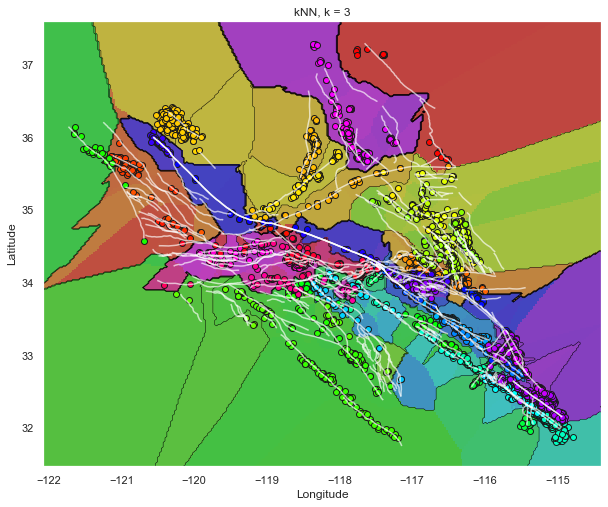

In [457]:
# Let's write a quick code to plot decision boundaries
def plot_decision_boundary(X, y, model, title, ax, class_colors):
    plot_eq_data(ax, X, y, class_colors)
    overlay_decision_boundary(ax, model_knn, class_label_vals = y, colors = class_colors)
    ax.set_title(title)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
CFM_full.plot(ax=ax, color = 'w', alpha = 0.66)
#plot_decision_boundary(X[0:9000, :], y[0:9000], model_knn, 'kNN, k = 3', ax, class_colors)
plot_decision_boundary(X, y, model_knn, 'kNN, k = 3', ax, class_colors)

# Unfortunately, it doesn't seem like these clustering algorithms are accurate at assigning earthquakes to faults. Let's switch gears and see if we can predict future earthquakes on a specific fault using a LSTM using a much larger data set of earthquakes.

In [2]:
# Let's load in the QTM dataset - This data set was created using a machine learning algorithm for picking earthquakes

qtm_df = pd.read_csv('Data/qtm_final_12dev.hypo.csv')
qtm_gpd = gpd.GeoDataFrame(qtm_df, geometry=[Point(x, y) for x, y in zip(qtm_df.LONGITUDE, qtm_df.LATITUDE)])
print(qtm_gpd.shape)
qtm_gpd.head()
print(min(qtm_gpd['MAGNITUDE']))

(898597, 18)
-1.95


In [205]:
# Let's investigate the San Jacinto Fault System. It has the most earthquakes of any in this data set

index = []
for i in np.arange(0,len(CFM_full['Layer'])):
    if "SJFZ" in CFM_full['Layer'][i]:
        index.append(i)
CFM_SJFZ = CFM_full.iloc[index].reset_index()
CFM_SJFZ.head()

level_0  index                                              Layer  \
0       12     12   PNRA-SJFZ-ANZA-Clark_fault_south_west-CFM4-trace   
1       15     15  PNRA-SJFZ-ANZA-Clark_fault_south_west_link-CFM...   
2       18     18  PNRA-SJFZ-ANZA-Clark_fault_south_west_link-CFM...   
3       25     25  PNRA-SJFZ-BRMT-Coyote_Creek_blind_fault_north_...   
4       44     44          PNRA-SJFZ-IMPV-Dixieland_fault-CFM5-trace   

   belowTopoA _isBlind    midZ  \
0   -3956.100        1 -3912.0   
1    -563.899        1 -3463.0   
2    -563.899        1  1363.0   
3   -3043.030        1 -3000.0   
4    -969.896        1 -1000.0   

                                            geometry  
0  LINESTRING Z (-116.0180068193446 33.1970443465...  
1  LINESTRING Z (-116.0982258818555 33.2350442488...  
2  LINESTRING Z (-116.5872095470034 33.5527446659...  
3  LINESTRING Z (-116.074035906744 33.13570704894...  
4  LINESTRING Z (-115.5077781731971 32.6823387608...

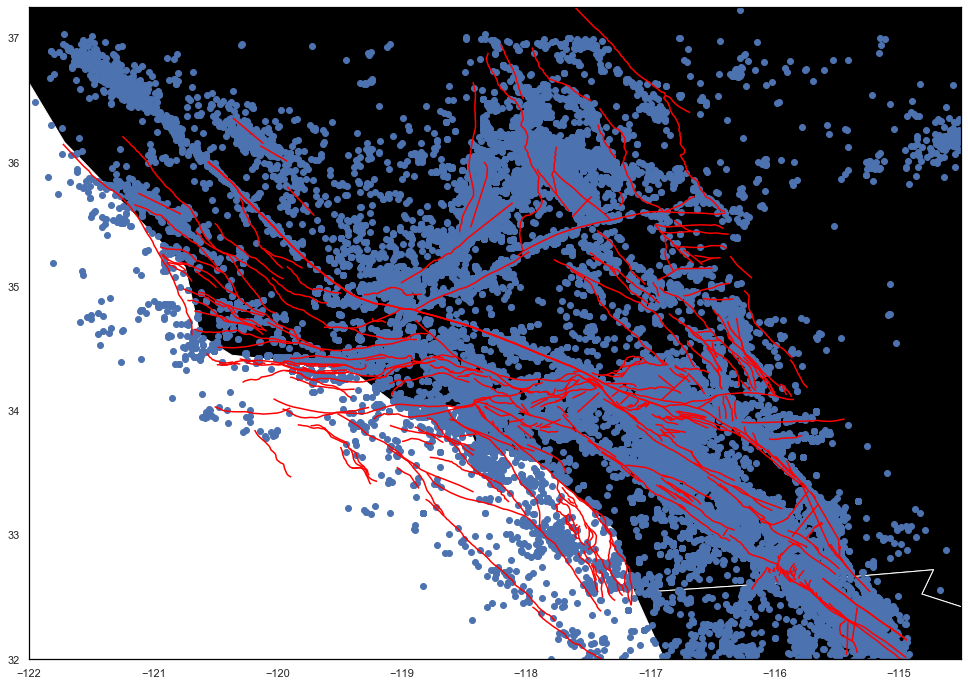

In [9]:
# Let's find and plot only earthquakes that occur close to this fault system.

#qtm_gpd = qtm_gpd[(qtm_gpd['LATITUDE']<=34.4) & (qtm_gpd['LATITUDE']>=32.6) & 
                 # (qtm_gpd['LONGITUDE'] >= -117.75) & (qtm_gpd['LONGITUDE'] <= -115.25)]
#print(qtm_gpd.shape)

# Set up Figure
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')

# Plot
# Plot the Basemap
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')
plt.setp(ax.spines.values(), color='black')
base = world.plot(ax=ax,color='black', edgecolor='white')
qtm_gpd.plot(ax=ax)

# Entire Community Fault Model
CFM1 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_blind.shp')
CFM2 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_nonblind.shp')
CFM_full = pd.concat([CFM1, CFM2],axis=0).reset_index()


CFM_full.plot(ax=ax, color='red')

# Set the view limit to only area of interest
ax.set_ylim(32,37.25)
ax.set_xlim(-122,-114.5);

In [209]:
# # There are earthquakes here that clearly did not occur on the San Jacinto Fault Zone.
# # Let's find the closest 300,000
# n = 300000

# def min_distance(point, lines):
#     return lines.distance(point).min()

# qtm_gpd['min_dist_to_lines'] = qtm_gpd.geometry.apply(min_distance, args=(CFM_SJFZ,))
# qtm_gpd = qtm_gpd[qtm_gpd['min_dist_to_lines'].isin(heapq.nsmallest(n,qtm_gpd['min_dist_to_lines']))]

# print(qtm_gpd.shape)

(300003, 19)


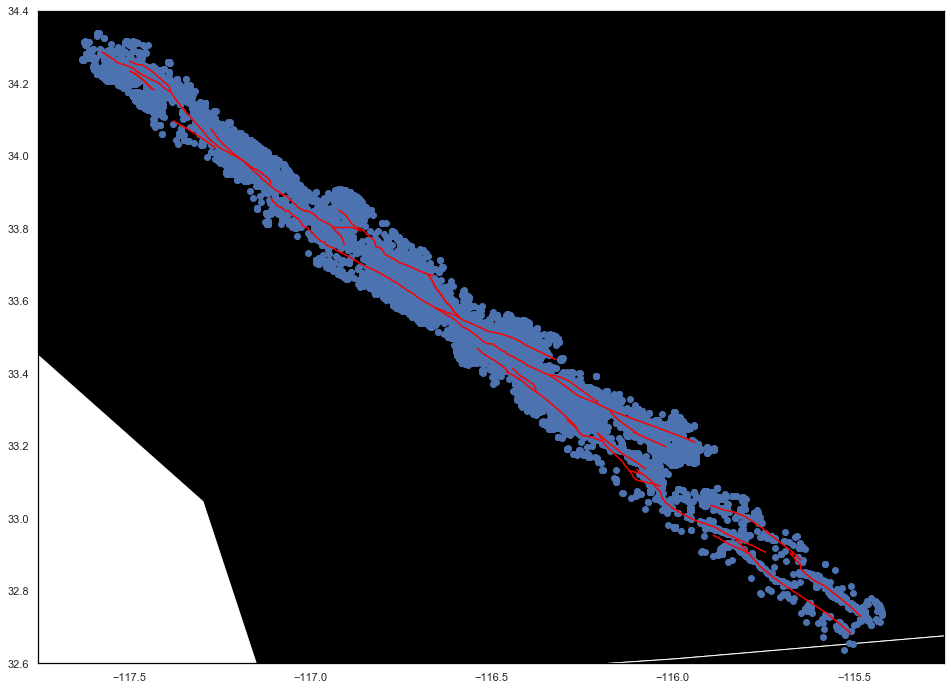

In [210]:
# # Let's plot these

# # Set up Figure
# fig, ax = plt.subplots(figsize = (30,12))
# ax.set_aspect('equal')
# ax.set_facecolor('white')

# # Plot
# plt.setp(ax.spines.values(), color='black')
# base = world.plot(ax=ax,color='black', edgecolor='white')
# qtm_gpd.plot(ax=ax)
# CFM_SJFZ.plot(ax=ax, color='red')

# # Set the view limit to only area of interest
# ax.set_ylim(32.6,34.4)
# ax.set_xlim(-117.75,-115.25);

In [10]:
# We must convert out data into a time series. Unfortunately, the day, month, and year are not clean for us.

qtm_gpd = qtm_gpd.reset_index()

dates = []

for i in np.arange(0,len(qtm_gpd['DAY'])):
    month = qtm_gpd['MONTH'][i]
    day = qtm_gpd['DAY'][i]
    year = qtm_gpd['YEAR'][i]
    
    # Use average days in each month
    if month >= 2:
        month = (month-1)*30.42
    else:
        month = month - 1
        
    # Use average days in each year
    if year >= 2009:
        year = (year-2008) * 365.2422
    else:
        year = year - 2008
    
    date_since_catalog_start = day + month + year
    dates.append(date_since_catalog_start)
    
qtm_gpd['dates_since_start_catalog'] = dates

qtm_gpd.head()

index  YEAR  MONTH  DAY  HOUR  MINUTE  SECOND  EVENTID  LATITUDE  \
0      0  2008      1    1     0       4  12.531        2  33.26719   
1      1  2008      1    1     0       4  18.539        3  33.45944   
2      2  2008      1    1     0       7  32.377        4  33.59068   
3      3  2008      1    1     0      58  57.842       10  33.49528   
4      4  2008      1    1     1      59  49.150       14  33.17647   

   LONGITUDE   DEPTH  MAGNITUDE  MAGP5  MAGP95  TEMPLATEID  STACKCC    MAD  \
0 -116.28997  11.567       0.78   0.59    0.90    37614600    0.348  0.026   
1 -116.58639  10.438       0.37   0.27    0.48    10310729    0.515  0.018   
2 -116.63390  13.378       0.38   0.28    0.47    37190560    0.404  0.017   
3 -116.49165  11.818       0.05  -0.10    0.18    15538673    0.216  0.014   
4 -115.59904   3.485      -0.53  -0.78   -0.29    14375564    0.312  0.023   

   RELOCATED?                     geometry  dates_since_start_catalog  
0           1  POINT (-116.28997 33.26719)                        1.0  
1           1  POINT (-116.58639 33.45944)                        1.0  
2           1   POINT (-116.6339 33.59068)                        1.0  
3           1  POINT (-116.49165 33.49528)                        1.0  
4           0  POINT (-115.59904 33.17647)                        1.0

Text(0, 0.5, 'Magnitude')

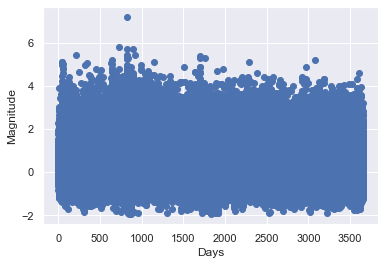

In [11]:
# Let's plot the time series

plt.scatter(qtm_gpd['dates_since_start_catalog'],qtm_gpd['MAGNITUDE'])
plt.xlabel('Days')
plt.ylabel('Magnitude')

In [14]:
# Let's bin on energy released per time

delta_t = 1
time=[]
energies = []
for i in np.arange(0,max(qtm_gpd['dates_since_start_catalog']),delta_t):
    time.append(i)
    eday = sum(np.exp((qtm_gpd.loc[(qtm_gpd['dates_since_start_catalog'] >= i) & 
                                 (qtm_gpd['dates_since_start_catalog'] < i+delta_t)]['MAGNITUDE'].values)*1.44 + 5.24))
    energies.append(eday)

Text(0, 0.5, 'Energy Release')

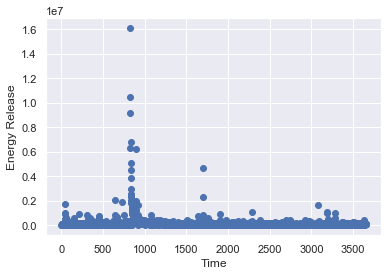

In [15]:
# Let's plot this new time series

plt.scatter(time,energies)
plt.xlabel('Time')
plt.ylabel('Energy Release')

(0, 400000.0)

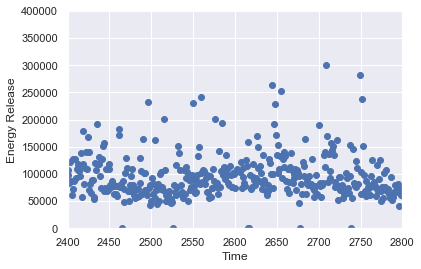

In [33]:
# Let's plot this new time series

plt.scatter(time,energies)
plt.xlabel('Time')
plt.ylabel('Energy Release')
plt.xlim([2400,2800])
plt.ylim([0,0.4e6])

In [ ]:
# the largest event occurs during this time. M 5.43

qtm_gpd[(qtm_gpd['MAGNITUDE'] == heapq.nlargest(1,qtm_gpd['MAGNITUDE'])[0])]

# https://www.latimes.com/archives/la-xpm-2010-jul-08-la-me-quake-20100708-story.html

In [35]:
# Let's try out the LSTM approach

time = np.asarray(time)
energies = np.asarray(energies)
#count = np.asarray(count)

In [36]:
# split time series into train/test sets 

def train_test_split(t, y, split = 0.8):
  '''
  : param t: time data 
  : para y: feature 
  : para split: percent of data to include in training set
  : return: t/y training/test arrays (shape: [# samples, 1]) 
  '''
  
  indx_split = int(split * len(y))
  indx_train = np.arange(0, indx_split)
  indx_test = np.arange(indx_split, len(y))
  
  # The reshape will put it into an array with the number of elements x 1
  # We need a data cube later when we do the LSTM
  # Array of arrays with just one value in them - 
  # If you had multiple variables going into it you would be able to incorporate this
  t_train = t[indx_train]
  y_train = y[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_test = t[indx_test]
  y_test = y[indx_test]
  y_test = y_test.reshape(-1, 1)
  
  return t_train, y_train, t_test, y_test 
  

In [64]:
t_train, y_train, t_test, y_test = train_test_split(time, energies, split = 0.8)

In [65]:
print(t_train.shape)
print(t_test.shape)

(2922,)
(731,)


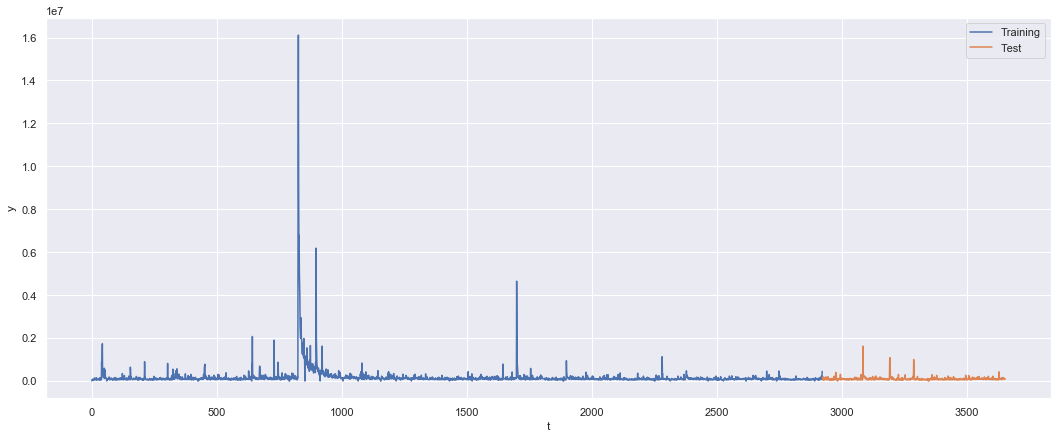

In [66]:
# plot train/test data

plt.figure(figsize=(18,7))
plt.plot(t_train,y_train,label = 'Training')
plt.plot(t_test,y_test,label = 'Test')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc=1)
plt.show()

In [67]:
# standardize the data

def standardize_data(y_train, y_test):
    train_mean = y_train.mean() 
    train_std = y_train.std() 
    
    y_train_stand = (y_train - train_mean) / train_std
    y_test_stand = (y_test - train_mean) / train_std
    
    return y_train_stand, y_test_stand

In [68]:
# Should have Std of 1 and Mean 0

y_train_stand, y_test_stand = standardize_data(y_train, y_test)
y_train_stand.mean(), y_train_stand.std()

(2.9180399825876805e-17, 1.0)

In [69]:
def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
    '''
    : param y: time series feature
    : param input_window: number of y samples to give model 
    : param output_window: number of future y samples to predict  
    : param stide: spacing between windows 
    : param num_features: number of features (i.e., 1 for us, but we could have multiple features)
    : return: array with correct dimensions for LSTM (i.e., [# samples, time steps, # features])
    '''
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1
    print(num_samples)

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y

In [70]:
# generate windowed training/test datasets

iw = 30
ow = 5
s = 2

Xtrain, Ytrain = windowed_dataset(y_train_stand, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = windowed_dataset(y_test_stand, input_window = iw, output_window = ow, stride = s)

1444
349


In [43]:
# check the shape of the data 

print(f'Xtrain has shape {Xtrain.shape} and Ytrain has shape {Ytrain.shape}')
print(f'Xtest has shape {Xtest.shape} and Ytest has shape {Ytest.shape}')

Xtrain has shape (30, 1444, 1) and Ytrain has shape (5, 1444, 1)
Xtest has shape (30, 349, 1) and Ytest has shape (5, 349, 1)


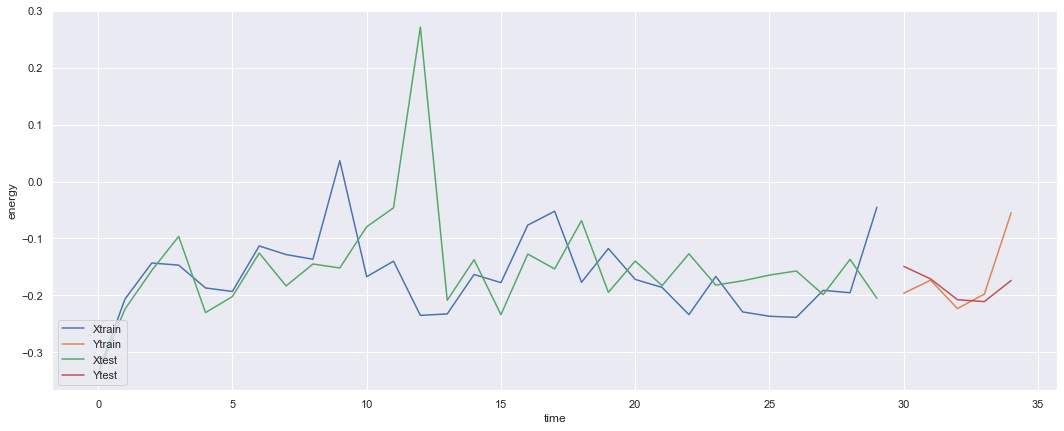

In [52]:
# plot an example in the windowed data 

time_i = 30
plt.figure(figsize=(18,7))
plt.plot(Xtrain[:,time_i,0],label = 'Xtrain')
plt.plot(np.arange(iw,iw+ow),Ytrain[:,time_i,0],label = 'Ytrain')
plt.plot(Xtest[:,time_i,0],label = 'Xtest')
plt.plot(np.arange(iw,iw+ow),Ytest[:,time_i,0],label = 'Ytest')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend(loc=3)
plt.show()

In [71]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        '''
        : param input_size: the number of expected features in the input x
        : param hidden_size: the number of features in the hidden state h
        : param num_layers: number of recurrent layers (i.e., 2 means there are
        :                   2 stacked LSTMs)
        '''
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        '''
        : param x_input: input of shape (seq_len, # in batch, input_size)
        '''
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        : param batch_size: x_input.shape[1]
        '''
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        '''
        LSTMCell takes in (batch size, input size/# features)
        : param x_input: should be 2D (batch_size, input_size)
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden


In [72]:
# Tensors are numpy arrays - works the same except they run natively with GPUs

class lstm_seq2seq(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, teacher_forcing_ratio, learning_rate = 0.01, dynamic_tf = False):
        '''
        train data using teacher forcing
        : param teacher_forcing_ratio: float [0, 1); high means more teacher forcing 
        '''
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)
        losses_tf = np.full(n_epochs, np.nan)
        losses_no_tf = np.full(n_epochs, np.nan)


        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        # looping through each entire epoch through the training data - through full data set - seen it all at once
        with tnrange(n_epochs) as tr:
            for it in tr:
                
                # training data is separated into batches
                # update the weights after each batch
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    use_teacher_forcing = ( random.random() < teacher_forcing_ratio )

                    # establish the random chance of teacher forcing in the decoder block
                    if use_teacher_forcing:
                        # teacher forcing: feed the target as the next input
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = target_batch[t, :, :]

                    else:
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    # compute the loss
                    loss = criterion(outputs, target_batch)

                    batch_loss += loss.item()
                    
                    if use_teacher_forcing:
                        num_tf += batch_size
                        batch_loss_tf += loss.item()
                    else:
                        num_no_tf += batch_size
                        batch_loss_no_tf += loss.item()

                    # Does the entire gradient descent and backpropagation - all derivitives all the way through
                    loss.backward()

                    optimizer.step()

                batch_loss /= (n_batches * batch_size)
                losses[it] = batch_loss

                
                if num_no_tf != 0.: 
                    batch_loss_no_tf /= num_no_tf
                    losses_no_tf[it] = batch_loss_no_tf

                    
                if num_tf !=0:
                    batch_loss_tf /= num_tf
                    losses_tf[it] = batch_loss_tf

                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 
                    
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses, losses_tf, losses_no_tf

    def predict(self, input_tensor, target_len):
        '''
        : param input_tensor: (seq_len, input_size)
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


In [77]:
# We make these numpy arrays into torch arrays so they can backpropagate

# the data needs to be in a torch format, not np.array
X_train = torch.from_numpy(Xtrain).type(torch.Tensor)
Y_train = torch.from_numpy(Ytrain).type(torch.Tensor)

X_test = torch.from_numpy(Xtest).type(torch.Tensor)
Y_test = torch.from_numpy(Ytest).type(torch.Tensor)
input_size = X_train.shape[2]

# specify model parameters and train 
hidden_size = 15   # how much memory 
n_epochs = 1000      # num of times going through full dataset 
batch_size = 10     # how many windowed examples you look at before changing the weights 
teacher_forcing_ratio = 0.9 
lr = 0.01         
# Dynamic TF True of false, change it 


model = lstm_seq2seq(input_size = input_size, hidden_size = hidden_size)
loss, loss_tf, loss_no_tf = model.train_model(X_train, Y_train, n_epochs = n_epochs, target_len = ow, batch_size = 5, teacher_forcing_ratio = teacher_forcing_ratio, learning_rate = lr, dynamic_tf = False)


Text(0, 0.5, 'Loss')

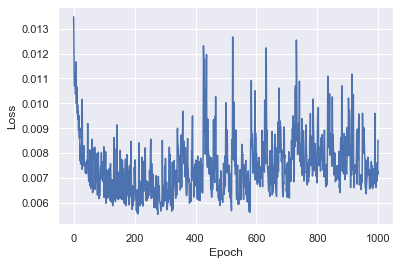

In [81]:
# Plot loss

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [79]:
def plot_train_test_results(lstm_model, num_rows = 4): 
  num_cols = 2
  num_plots = num_rows * num_cols
# the number of rows is the number of examples I want to show.
  fig, ax = plt.subplots(num_rows, num_cols, figsize = (8, 12))
# add for loop here to plot all of the dimensions ( this is where the 0 is - this is plotting the first dimension)
  for ii in range(num_rows):
      # train set
      X_train_plt = X_train[:, ii, :]
      Y_train_pred = lstm_model.predict(X_train_plt, target_len = ow)
      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, ii, 0], 'k', label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, ii, 0]], Ytrain[:, ii, 0]]), 'b', label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, ii, 0]], Y_train_pred[:, 0]]), 'r', label = 'Prediction')
      ax[ii, 0].set_xlabel('t')
      ax[ii, 0].set_ylabel('y')


      # test set
      X_test_plt = X_test[:, ii, :]
      Y_test_pred = lstm_model.predict(X_test_plt, target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, ii, 0], 'k', label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Ytest[:, ii, 0]]), 'b', label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Y_test_pred[:, 0]]), 'r', label = 'Prediction')
      ax[ii, 1].set_xlabel('t')
      ax[ii, 1].set_ylabel('y')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

        
  return 

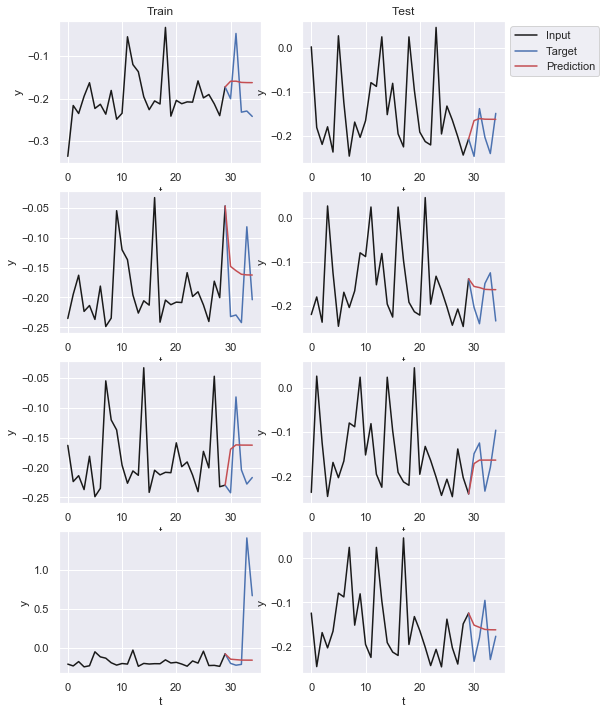

In [80]:
# plot results

plot_train_test_results(model)

# Welp, that didn't work. Likely because there is no underlying curve to learn. Let's try the approach now on a dataset where we can see a clear trend. We are going to look at GPS measurements on the Cascadia subduction zone

In [213]:
# Cascadia Subduction Zone GPS Measurements

p159 = pd.read_csv('Data/Cascadia/P159.pbo.final_nam08.csv')
albh = pd.read_csv('Data/Cascadia/ALBH.pbo.final_nam08.csv')
eliz = pd.read_csv('Data/Cascadia/ELIZ.pbo.final_nam08.csv')

# Add a time series component

eliz['days_since_start'] = np.arange(0,len(eliz))
p159['days_since_start'] = np.arange(0,len(p159))
albh['days_since_start'] = np.arange(0,len(albh))

dataset = albh

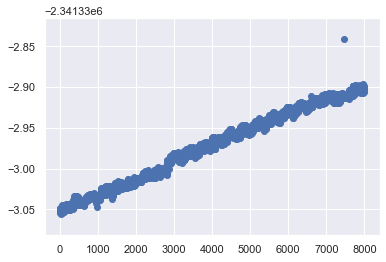

In [217]:
# Let's plot the data
# Play around plotting the X, Y, and Z components

plt.scatter(dataset['days_since_start'], dataset['X'])

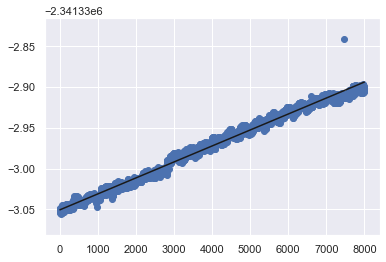

In [222]:
# Let's remove the linear trend - we want our LSTM to learn the sinusoidal nature of the curve do to slow-slip events

# Find the linear trend

poly = np.polyfit(dataset['days_since_start'],dataset['X'],1)
p = np.poly1d(poly)
px = np.linspace(dataset['days_since_start'].min(), dataset['days_since_start'].max(), len(dataset['days_since_start']))
py = p(np.linspace(dataset['days_since_start'].min(), dataset['days_since_start'].max(), len(dataset['days_since_start'])))
plt.scatter(dataset['days_since_start'], dataset['X'])
plt.plot(px,py,color = 'k')

In [231]:
# Remove the linear trend

data_choice = dataset['X'] - py

time = np.asarray(dataset['days_since_start'])
positions = np.asarray(data_choice)

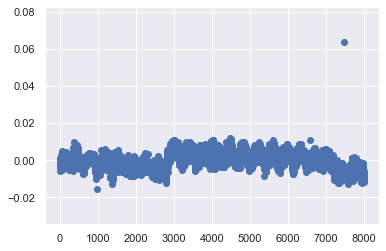

In [232]:
# Plot the time series without the linear trend

plt.scatter(time,positions)

In [239]:
# Split the data

t_train, y_train, t_test, y_test = train_test_split(time, positions, split = 0.8)

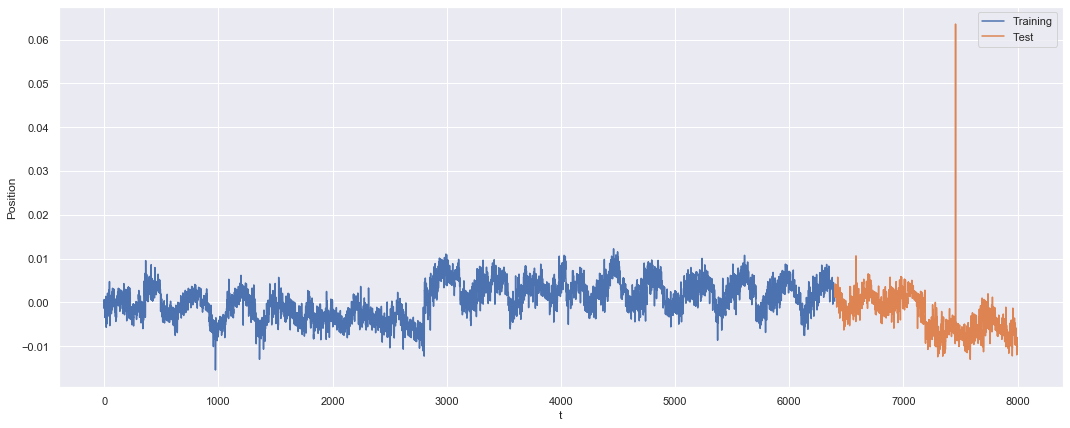

In [240]:
# plot train/test data

plt.figure(figsize=(18,7))
plt.plot(t_train,y_train,label = 'Training')
plt.plot(t_test,y_test,label = 'Test')
plt.xlabel('t')
plt.ylabel('Position')
plt.legend(loc=1)
plt.show()

In [ ]:
# Standardize

y_train_stand, y_test_stand = standardize_data(y_train, y_test)

In [ ]:
# set size of input/output windows 

iw = 200
ow = 20
s = 5

# generate windowed training/test datasets

Xtrain, Ytrain = windowed_dataset(y_train_stand, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = windowed_dataset(y_test_stand, input_window = iw, output_window = ow, stride = s)

In [ ]:
# check the shape of the data 

print(f'Xtrain has shape {Xtrain.shape} and Ytrain has shape {Ytrain.shape}')
print(f'Xtest has shape {Xtest.shape} and Ytest has shape {Ytest.shape}')

In [ ]:
# plot an example in the windowed data 

time_i = 0
plt.figure(figsize=(18,7))
plt.plot(Xtrain[:,time_i,0],label = 'Xtrain')
plt.plot(np.arange(iw,iw+ow),Ytrain[:,time_i,0],label = 'Ytrain')
plt.plot(Xtest[:,time_i,0],label = 'Xtest')
plt.plot(np.arange(iw,iw+ow),Ytest[:,time_i,0],label = 'Ytest')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend(loc=3)
plt.show()

In [ ]:
# We make these numpy arrays into torch arrays so they can backpropagate

# the data needs to be in a torch format, not np.array
X_train = torch.from_numpy(Xtrain).type(torch.Tensor)
Y_train = torch.from_numpy(Ytrain).type(torch.Tensor)

X_test = torch.from_numpy(Xtest).type(torch.Tensor)
Y_test = torch.from_numpy(Ytest).type(torch.Tensor)
input_size = X_train.shape[2]

# specify model parameters and train 
hidden_size = 15   # how much memory 
n_epochs = 10      # num of times going through full dataset 
batch_size = 5     # how many windowed examples you look at before changing the weights 
teacher_forcing_ratio = 0.1 
lr = 0.01         
# Dynamic TF True of false, change it 


model = lstm_seq2seq(input_size = input_size, hidden_size = hidden_size)
loss, loss_tf, loss_no_tf = model.train_model(X_train, Y_train, n_epochs = n_epochs, target_len = ow, batch_size = batch_size, teacher_forcing_ratio = teacher_forcing_ratio, learning_rate = lr, dynamic_tf = False)


In [ ]:
# plot loss 

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plot results

plot_train_test_results(model)